<h1>Исследование оттока клиентов для сети фитнес-центров<span class="tocSkip"></span></h1>

1. Загрузка данных
2. Исследовательский анализ данных (EDA)
3. Построение модели прогнозирования оттока клиентов
4. Кластеризация клиентов
5. Выводы и рекомендации

**Задача:** 

Проанализировать данные по оттоку клиентов сети фитнес-центров, подготовить рекомендации по их удержанию.

В этом исследовании мы будем использовать машинное обучение, с его помощью мы спрогнозируем вероятность оттока для каждого клиента (на уровне следующего месяца).  

Данные для прогноза:  

  `churn` - факт оттока в текущем месяце  
  `contract_period` - длительность текущего действующего абонемента  
  `month_to_end_contract` - срок до окончания текущего действующего абонемента  
  `avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента  
  `avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц  
  
В дальнейшем модель будет использоваться отделом по работе с клиентами, сотрудники смогут своевременно принимать меры для предотвращения оттока. Ожидаемый бизнес-эффект: увеличение LTV клиентов, как следствие - увеличение прибыли. 
  
Метрики оценки качества работы модели:  
    
- **Accuracy**  

    Доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше.    
    
    
- **Precision**   

    Метрика говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов
    только среди целевого класса. В нашем случае метрика precision нужна, так как каждое срабатывание модели — стоит
    ресурсов.  
    
    
- **Recall**   

    Метрика нацелена на минимизацию противоположных рисков, она показывает, сколько реальных объектов "1" класса мы
    смогли обнаружить с помощью модели. 

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set(rc={'figure.figsize':(10, 6)})

Посмотрим на данные.

In [2]:
gym_churn.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3925,1,0,0,0,1,1,0,31,9.59,1.00,14,2.13,2.15,0
208,1,1,0,0,1,1,0,23,131.11,1.00,0,1.69,2.28,1
780,0,1,0,1,1,1,0,21,164.37,1.00,0,1.68,0.87,1
1100,1,1,0,1,1,12,0,29,38.99,10.00,9,0.06,0.01,0
1423,1,1,0,0,1,1,1,29,107.46,1.00,5,1.92,1.97,0


In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
gym_churn.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Пропущенных значений нет. 

In [5]:
gym_churn = gym_churn.drop_duplicates().reset_index(drop=True)
print(gym_churn.duplicated().sum())

0


Дубликаты не обнаружены. 

In [6]:
gym_churn.columns = map(str.lower, gym_churn.columns)
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

In [7]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Вывод по разделу:**  

Мы загрузили данные, проверили датасет на предмет пропущенных значений и дубликатов (их нет). Для удобства дальнейшей работы привели названия столбцов к нижнему регистру. Практически все столбцы имеют соответствующий своему значению тип данных, за исключением столбца `month_to_end_contract` - здесь необходимы целые значения, поэтому тип данных изменен. 

## Исследовательский анализ данных (EDA)

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения.

In [8]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


1. Пользователи фитнес-центра разделились по половому признаку практически поровну.  
2. 85% клиентов проживают или работают в районе, где находится фитнес-центр.  
3. Чуть меньше половины клиентов являются сотрудниками партнерских организаций.
4. Около 30% клиентов изначально записались в рамках акции «приведи друга».  
5. Подавляющее большинство клиентов указало свой контактный телефон (90%). 
6. Средняя длительность действующего абонемента составляет 4-5 месяцев, однако чаще клиенты приобретают абонементы на 1 месяц.
7. Около 40% клиентов посещают групповые занятия.  
8. Средний возраст посетителей: 29 лет.  
9. Среднее значение выручки от других услуг фитнес-центра: 147 (данных о валюте нет).
10. Срок до окончания текущего действующего абонемента в среднем составляет около 4 месяцев.
11. Среднее время с момента первого обращения в фитнес-центр составляет 3,5 месяца.
12. Средняя частота посещений за все время с начала действия абонемента - около двух раз в неделю. 
13. Средняя частота посещений в неделю за предыдущий месяц - около двух раз в неделю.
14. Факт оттока в текущем месяце: 27%.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [9]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


1. Данные по гендерному распределению не изменились.  
2. Факт проживания или работы клиента в районе, где находится фитнес-центр имеет значение.  
3. Принадлежность клиента к сотрудникам партнерских организаций имеет значение.
4. Факт первоначальной записи в рамках акции «приведи друга» также выше у тех, кто остался.  
5. Наличие контактного телефон клиента не влияет на решение об уходе. 
6. Средняя длительность действующего абонемента выше у тех, кто остался.
7. Осташиеся клиенты чаще посещают групповые занятия.  
8. Средний возраст клиентов уходящих в отток: 27 лет.  
9. Среднее значение выручки от клиентов уходящих в отток: 115 (данных о валюте нет).
10. Количество месяцев до окончания текущего абонемента у тех, кто остался значительно выше.
11. Среднее время с момента первого обращения в фитнес-центр составляет 3,5 месяца.
12. Средняя частота посещений за все время выше у тех, кто остался. 
13. Средняя частота посещений в неделю за предыдущий месяц также выше у тех, кто остался.

Посмотрим на распределения признаков для двух групп. 

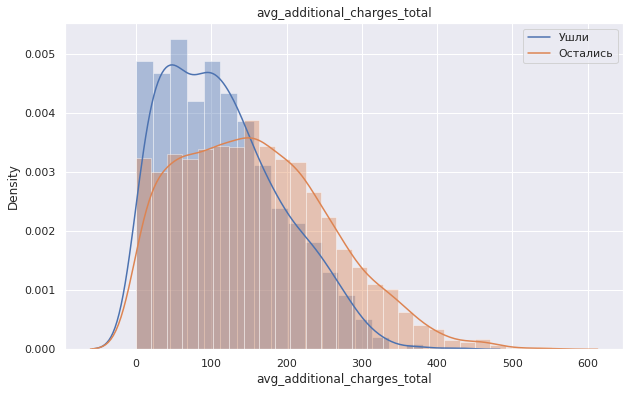

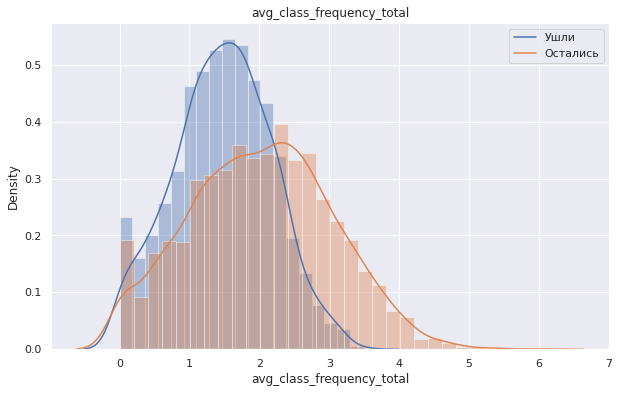

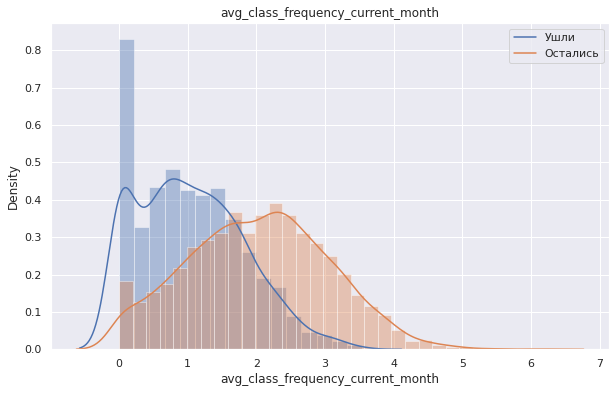

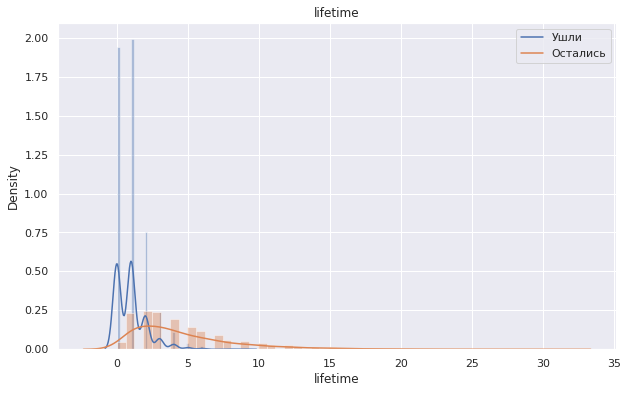

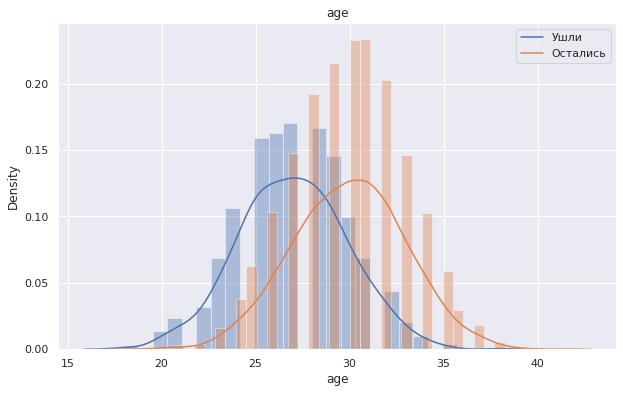

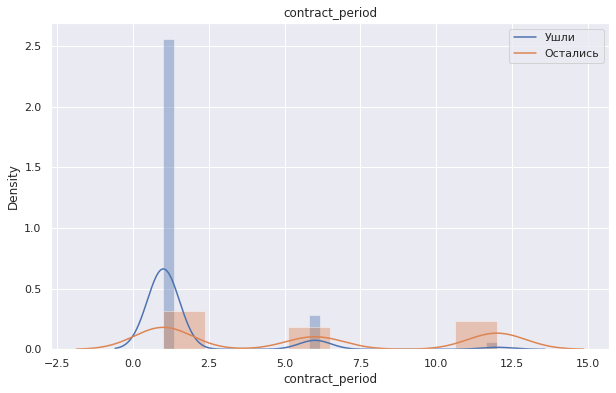

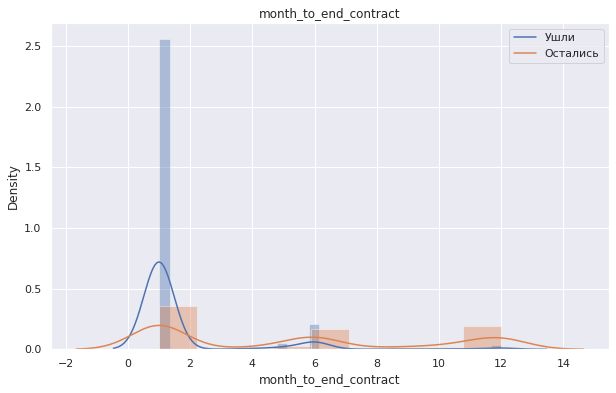

In [10]:
gone = gym_churn[gym_churn['churn']==1]
stayed = gym_churn[gym_churn['churn']==0]
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
for column in distplot_columns: 
    plt.title(column)
    sns.distplot(gone[column])
    sns.distplot(stayed[column])
    plt.legend(['Ушли', 'Остались'])
    plt.show()

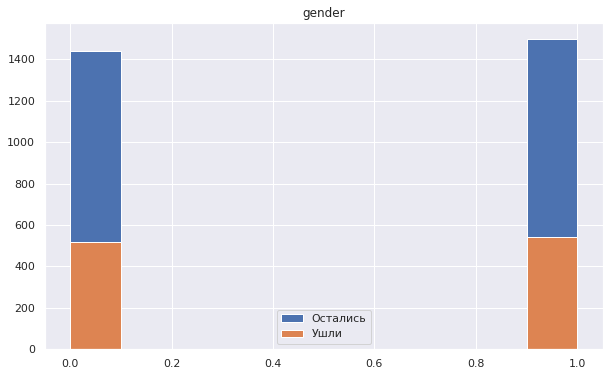

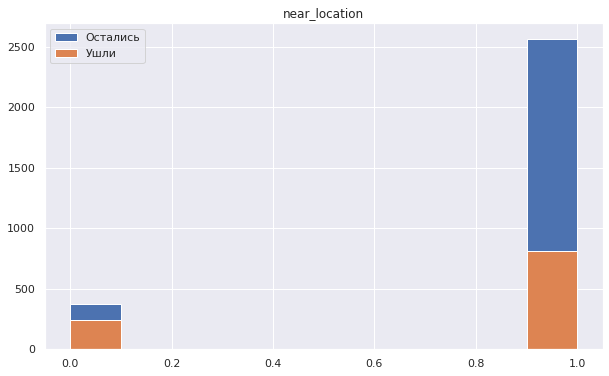

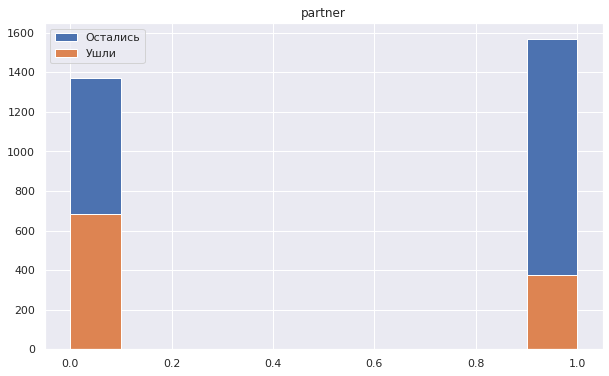

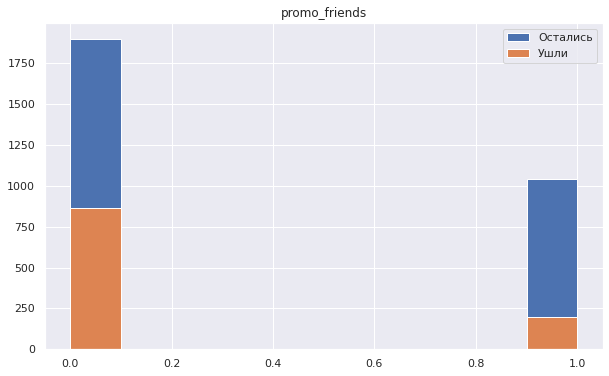

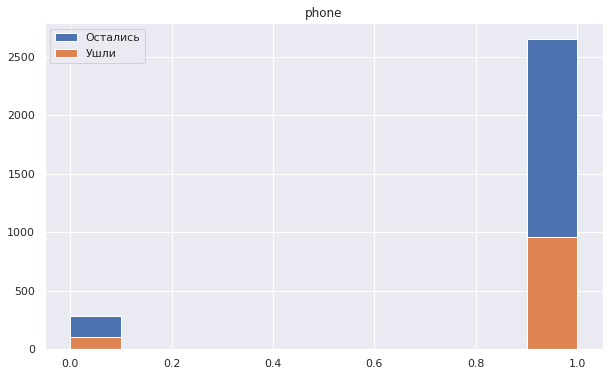

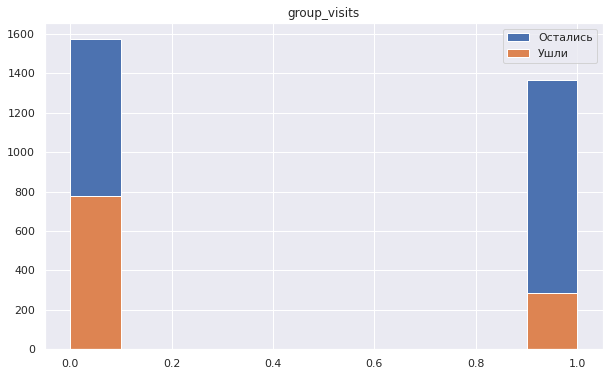

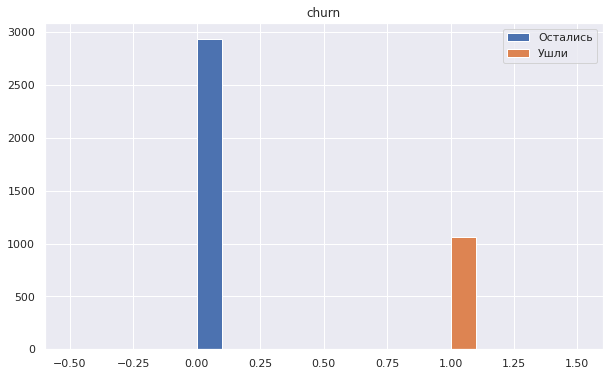

In [11]:
for column in gym_churn.columns:
    if column not in distplot_columns:
        gym_churn.groupby('churn')[column].hist()
        plt.title(column)
        plt.legend(['Остались', 'Ушли'])
        plt.show()

По полу и возрасту обе группы имеют нормальное распределение. Среди оставшихся клиентов сотрудников компании-партнёра заметно больше. Различия в распределении по групповым занятиям схожи с различиями в распределениях по признаку Partner. Также схожи распределения по признаку Promo_friends. Распределения по сроку абонемента различаются следующим образом: наибольшее количество лояльных клиентов, покупающих абонемент сроком на 1 месяц, на год покупают уже меньше, и совсем немного клиентов покупают абонементы на 6 и 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. Распределения частоты посещений в неделю имеют нормальный вид.

Построим матрицу корреляций, поищем зависимые признаки. 

In [12]:
correlation = gym_churn.corr()
correlation

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


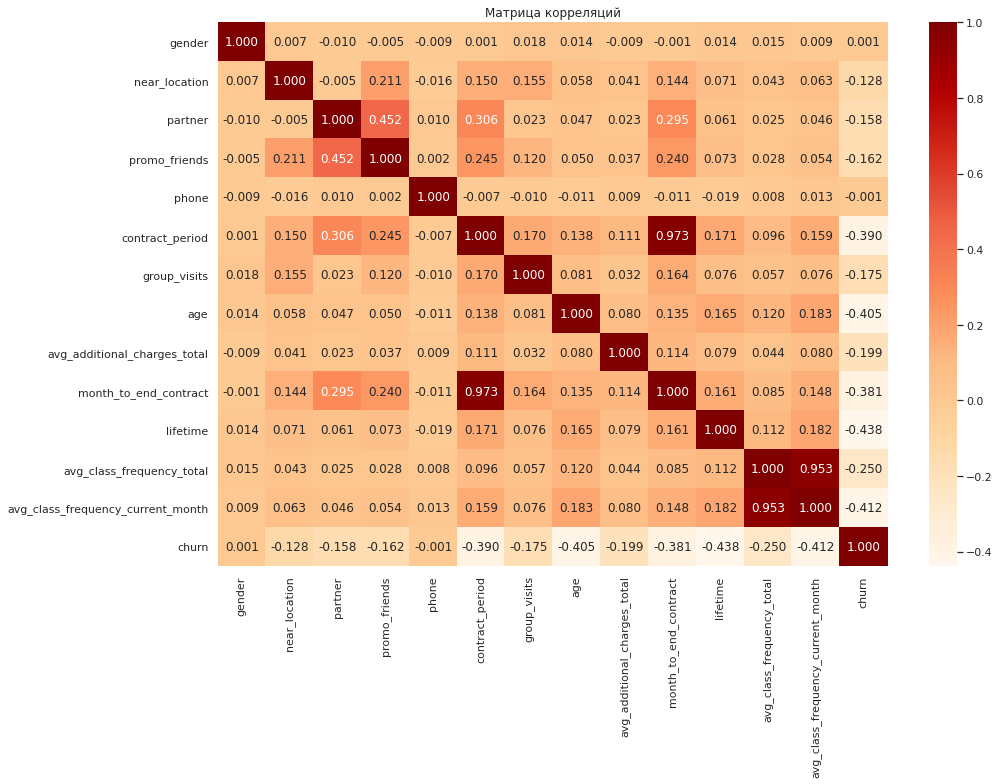

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(data = gym_churn.corr(), annot=True, fmt='.3f', cmap='OrRd')
plt.title('Матрица корреляций')
plt.show()

Обнаружена высокая корреляция между признаками:
  
- срок до окончания текущего действующего абонемента и длительность текущего действующего абонемента (month_to_end_contract и     contract_period) 97%.
- средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия
  абонемента (avg_class_frequency_current_month и avg_class_frequency_total) 95%.
  
Заметно коррелируют признаки:

- сотрудник компании-партнёра клуба и запись в рамках акции «приведи друга» (partner и promo_friends) 45%
- сотрудник компании-партнёра клуба и длительность текущего действующего абонемента (partner и contract_period) 30%

Заметно отрицательно коррелируют признаки:

- факт оттока в текущем месяце и время с момента первого обращения в фитнес-центр (churn и lifetime) - 43%
- факт оттока в текущем месяце и возраст клиента (churn и age) - 40%
- факт оттока в текущем месяце и длительность текущего действующего абонемента (churn и contract_period) - 39%

**Вывод по разделу:**  

На данном этапе удалось выяснить, что клиенты чаще уходят в отток, если: 

- им нужно добираться до фитнес-центра 
- они не являются сотрудниками компаний-парнёров и не пришли в рамках акции «приведи друга» 
- они не участвуют в групповых занятиях
- купили абонемент на 1 месяц
- их возраст менее 29 лет
- перестали посещать фитнес-центр в последний месяц 

Для того, чтобы такие признаки с высокой корреляцией не доминировали над остальными переменными при обучении, удалим из модели month_to_end_contract и avg_class_frequency_total.

In [14]:
gym_churn = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
Разбьем данные на обучающую и валидационную выборку функцией train_test_split().

In [15]:
# Разделим данные на признаки (матрица x) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:  

**Логистическая регрессия**

In [16]:
# Зададим алгоритм для модели
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# Обучим модель
lr_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

**Случайный лес**

In [17]:
# Зададим алгоритм для модели
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# Обучим модель
rf_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

Посмотрим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке.

In [18]:
# функция, которая принимает на вход модель и данные и выводит метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print('Метрики для модели логистической регрессии: \n')
print_metrics(y_test, lr_predictions, lr_probabilities, 'Метрики для модели логистической регрессии')

print('\n Метрики для модели случайного леса: \n')
print_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса')

Метрики для модели логистической регрессии: 

	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84

 Метрики для модели случайного леса: 

	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77


**Вывод по разделу:**  

При построении модели прогнозирования оттока клиентов мы разделили выборку на обучащую и валидационную в соотношении 80 к 20. Затем мы обучили модели на валидационной выборке двумя способами: логистической регрессией и случайным лесом.

Лучше показала себя модель логистической регрессии, в ее случае показатели доли правильных ответов и полноты оказались выше. 

Коэффициенты линейной регрессии хранятся в атрибуте обученной модели .coef_ :

In [19]:
#сохраним коэффициенты для всех признаков в переменной feature_weights(«веса признаков»)
feature_weights = lr_model.coef_ 
feature_weights

array([[ 0.02435228, -0.06325383, -0.05799998, -0.15007384, -0.07493617,
        -1.37710805, -0.37541984, -1.15510683, -0.56168546, -3.5486095 ,
        -1.27180585]])

In [20]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
lr_importances = pd.DataFrame(data={'feature': X.columns, 'importance': lr_model.coef_[0]})
lr_importances.sort_values(by='importance', ascending=True)

,feature,importance
9,lifetime,-3.55
5,contract_period,-1.38
10,avg_class_frequency_current_month,-1.27
7,age,-1.16
8,avg_additional_charges_total,-0.56
6,group_visits,-0.38
3,promo_friends,-0.15
4,phone,-0.07
1,near_location,-0.06
2,partner,-0.06


В случае логистической регрессии, обучение состоит в подборе коэффициентов для каждого признака. Так как эти признаки стандартизированы, значение коэффициента для каждого показывает его важность. В ходе обучения модель подобрала оптимальные коэффициенты. Даже небольшое изменение признаков lifetime, contract_period, avg_class_frequency_current_month может сильно повлиять на результат — то есть эти признаки очень важны для модели. Коэффициенты большинства признаков отрицательны, то есть если мы будем увеличивать значение этих признаков, прогнозная величина будет снижаться.

Чтобы вывести нулевой коэффициент (значение прогноза, когда значения всех признаков равны 0), используется атрибут .intercept_:

In [21]:
weight_0 = lr_model.intercept_
weight_0

array([-3.6900244])

В нашем случае отрицательный коэффициент означает, что факторы уменьшают риск (т.е. снижают вероятность анализируемого исхода - оттока), т.е. чем дольше клиент с фитнес-центром и чем чаще он этот центр посещает, тем меньше вероятность оттока. 

Важность признаков для случайного леса хранится в атрибуте обученной модели .feature_importances_:

In [22]:
rf_importances = rf_model.feature_importances_
rf_importances

array([0.01657355, 0.01304491, 0.01685355, 0.01360623, 0.00866216,
       0.11037678, 0.02076765, 0.14418638, 0.12238446, 0.31776213,
       0.21578221])

In [23]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
rf_importance = pd.DataFrame(data={'feature': X.columns, 'importance': rf_model.feature_importances_})
rf_importance.sort_values(by='importance', ascending=False)

,feature,importance
9,lifetime,0.32
10,avg_class_frequency_current_month,0.22
7,age,0.14
8,avg_additional_charges_total,0.12
5,contract_period,0.11
6,group_visits,0.02
2,partner,0.02
0,gender,0.02
3,promo_friends,0.01
1,near_location,0.01


Наиболее важными признаками оказались: время с момента первого обращения в фитнес-центр (lifetime) и средняя частота посещений в неделю за предыдущий месяц (avg_class_frequency_current_month). Это согласуется с ранее полученными выводами и подкрепляет итоговую гипотезу о наличии определенных сложностей в адаптации для новых клиентов. Также полученный результат говорит о том, что модель адекватно работает с признаками и отражает природу вещей. 

Логистическая регрессия снова показала себя лучше случайного леса. 

## Кластеризация клиентов

- Стандартизируем данные.

In [24]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

- Функцией linkage() построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму. 

In [25]:
linked = linkage(X_sc, method='ward')
linked

array([[5.47000000e+02, 3.88400000e+03, 1.11541554e-02, 2.00000000e+00],
       [1.46000000e+03, 1.53800000e+03, 2.48829986e-02, 2.00000000e+00],
       [2.36600000e+03, 3.42500000e+03, 2.93974563e-02, 2.00000000e+00],
       ...,
       [7.98400000e+03, 7.99500000e+03, 8.46938585e+01, 2.64900000e+03],
       [7.98500000e+03, 7.99600000e+03, 8.95369955e+01, 3.03500000e+03],
       [7.99200000e+03, 7.99700000e+03, 9.06663627e+01, 4.00000000e+03]])

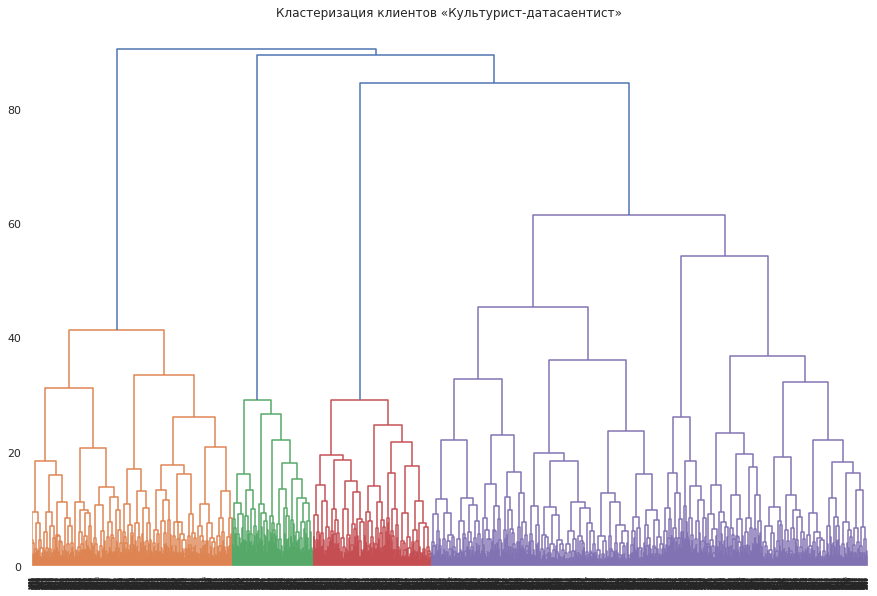

In [26]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов «Культурист-датасаентист»')
plt.show()

На основе полученной дендрограммы можно предположить наличие пяти кластеров, два из которых имеют довольно схожую структуру.

- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [27]:
# задаем модель k_means с числом кластеров - 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

- Посмотрим на средние значения признаков для кластеров.

In [28]:
gym_churn.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.50,1.00,0.89,1.00,1.00,6.92,0.52,29.61,153.42,4.28,1.92,0.12
1,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.97,1.60,0.40
2,0.50,1.00,0.22,0.07,1.00,2.01,0.28,27.58,119.34,1.92,1.20,0.56
3,0.53,1.00,0.38,0.01,1.00,6.21,0.54,30.70,176.26,5.42,2.32,0.01
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.72,0.27


**Кластер 0** (Отток - 12%)  

Эти клиенты живут или работают в районе, где находится фитнес-центр, в основном это сотрудники компании-партнёра и участники акции «приведи друга». Владельцы долгосрочных абонементов, которые посещают групповые занятия и пользуются дополнительными услугами фитнес-центра.

**Кластер 1** (Отток - 40%)

Эти клиенты вынуждены добираться до фитнес-центр, примерно половина из них являются сотрудниками компании-партнёра. Обладатели абонементов сроком на 3 месяца, они посещают групповые занятия и пользуются дополнительными услугами фитнес-центра (но уже не так активно, чем нулевой кластер).

**Кластер 2** (Отток - 56%)  

Эти клиенты живут или работают в районе, где находится фитнес-центр, однако, среди них меньше всего сотрудников компании-партнёра. Они не очень активно посещают групповые занятия и меньше всех пользуются дополнительными услугами фитнес-центра. Также необходимо учесть признаки lifetime и age этих клиентов, это самый молодой кластер.

**Кластер 3** (Отток - 1%)   

Здесь есть хоть и небольшое различие по гендерной принадлежности. Эти клиенты живут или работают в районе, где находится фитнес-центр, часть из них сотрудники компании-партнёра (около 40%). Это владельцы долгосрочных абонементов, которые наиболее активно посещают групповые занятия и пользуются дополнительными услугами фитнес-центра. У этих клиентов наиболее высокие показатели lifetime и age. Похоже, мы вышли на целевую аудиторию фитнес-центра. 

**Кластер 4** (Отток - 27%)  

Эти клиенты живут или работают поблизости, почти 50% из них - сотрудники компании-партнёра, а 30% - участники акции «приведи друга». У них долгосрочные абонементы, они посещают групповые занятия и пользуются дополнительными услугами фитнес-центра, но по каким-то причинам с этим кластером нет связи, никто не указал свой телефон. 

- Построим распределения признаков для кластеров.

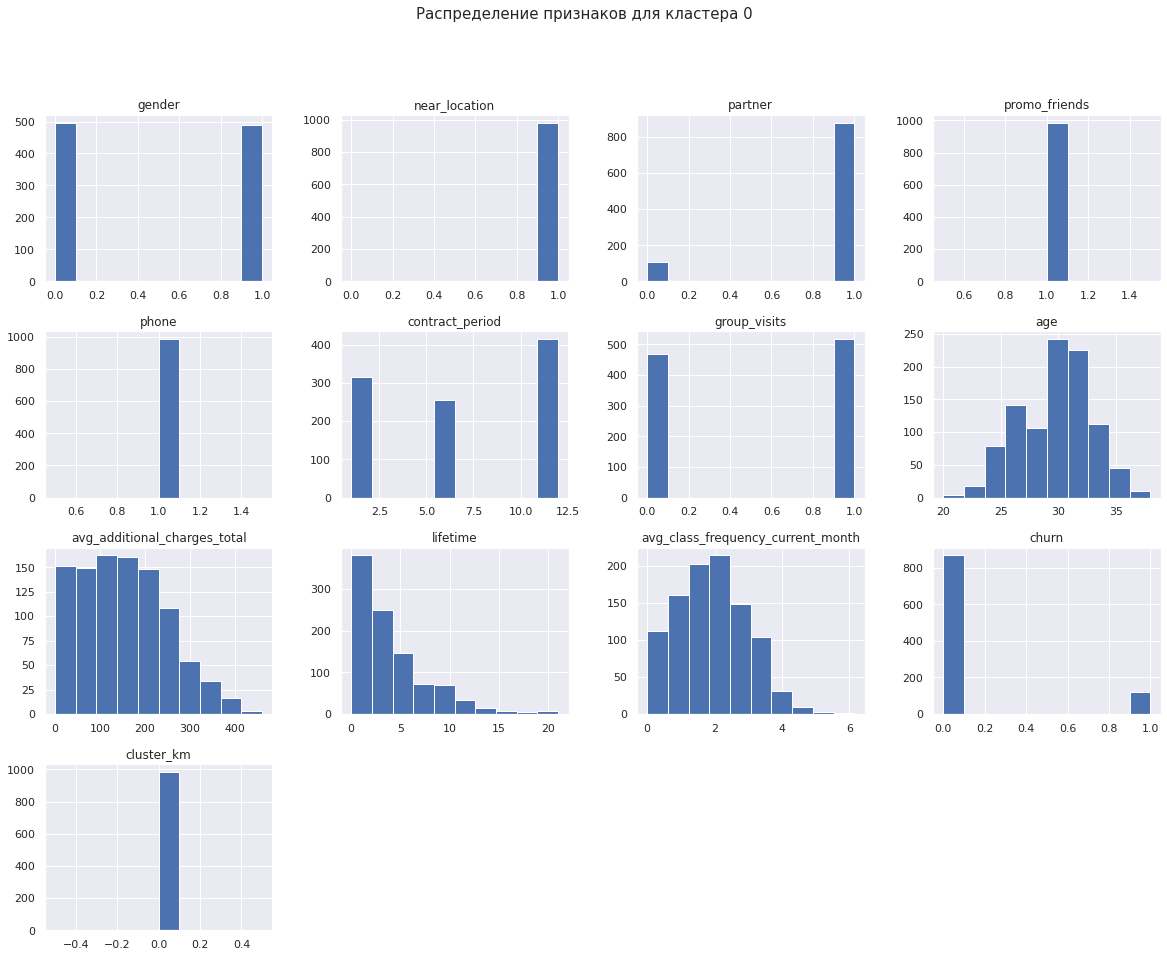

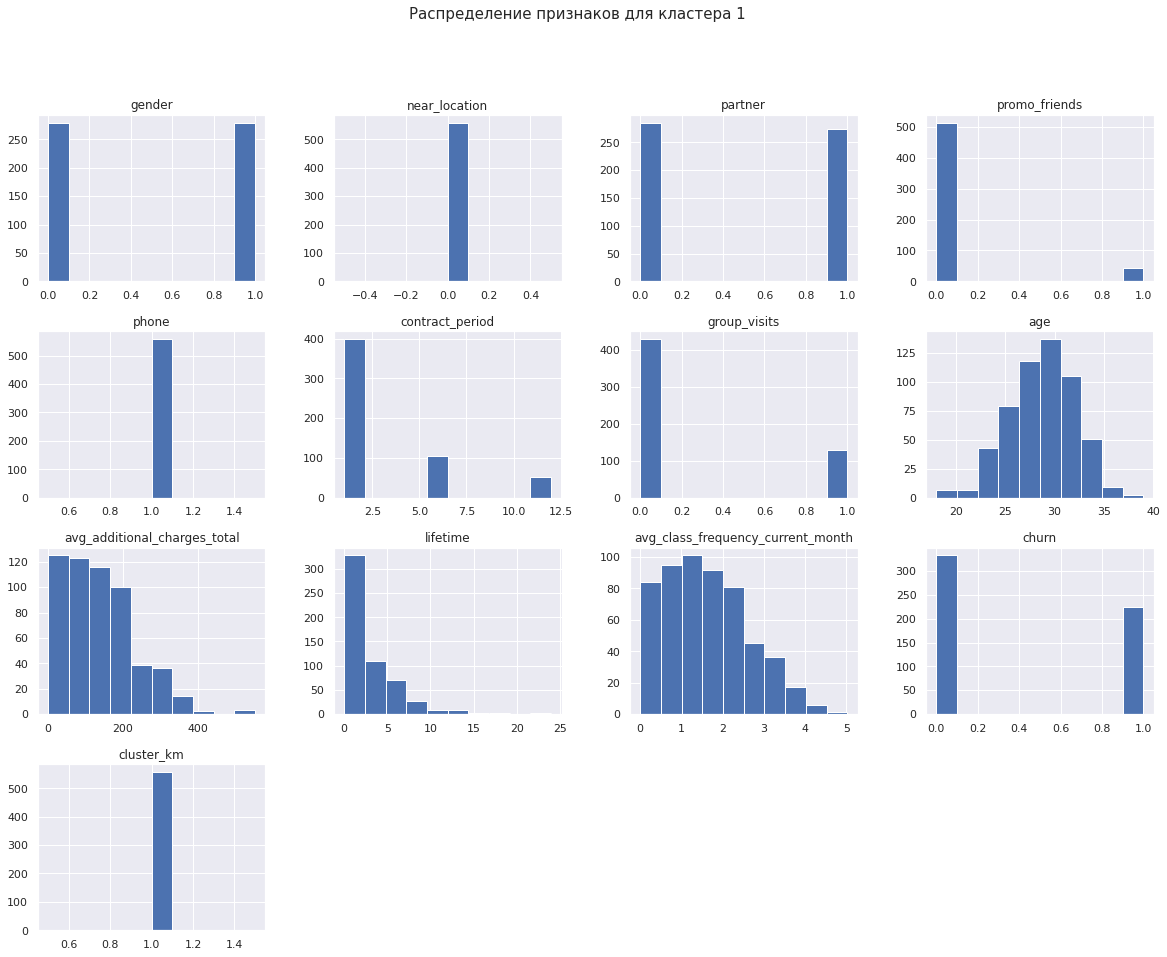

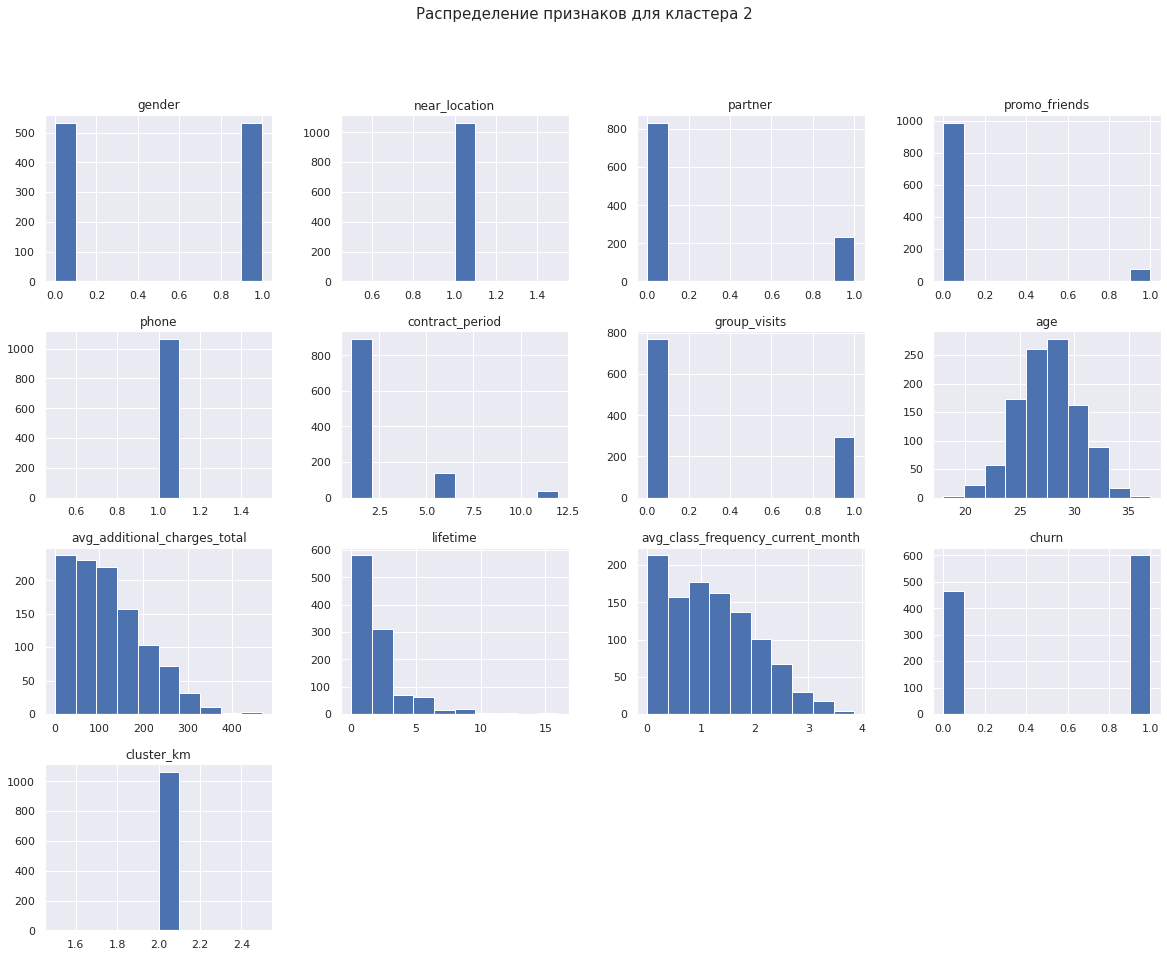

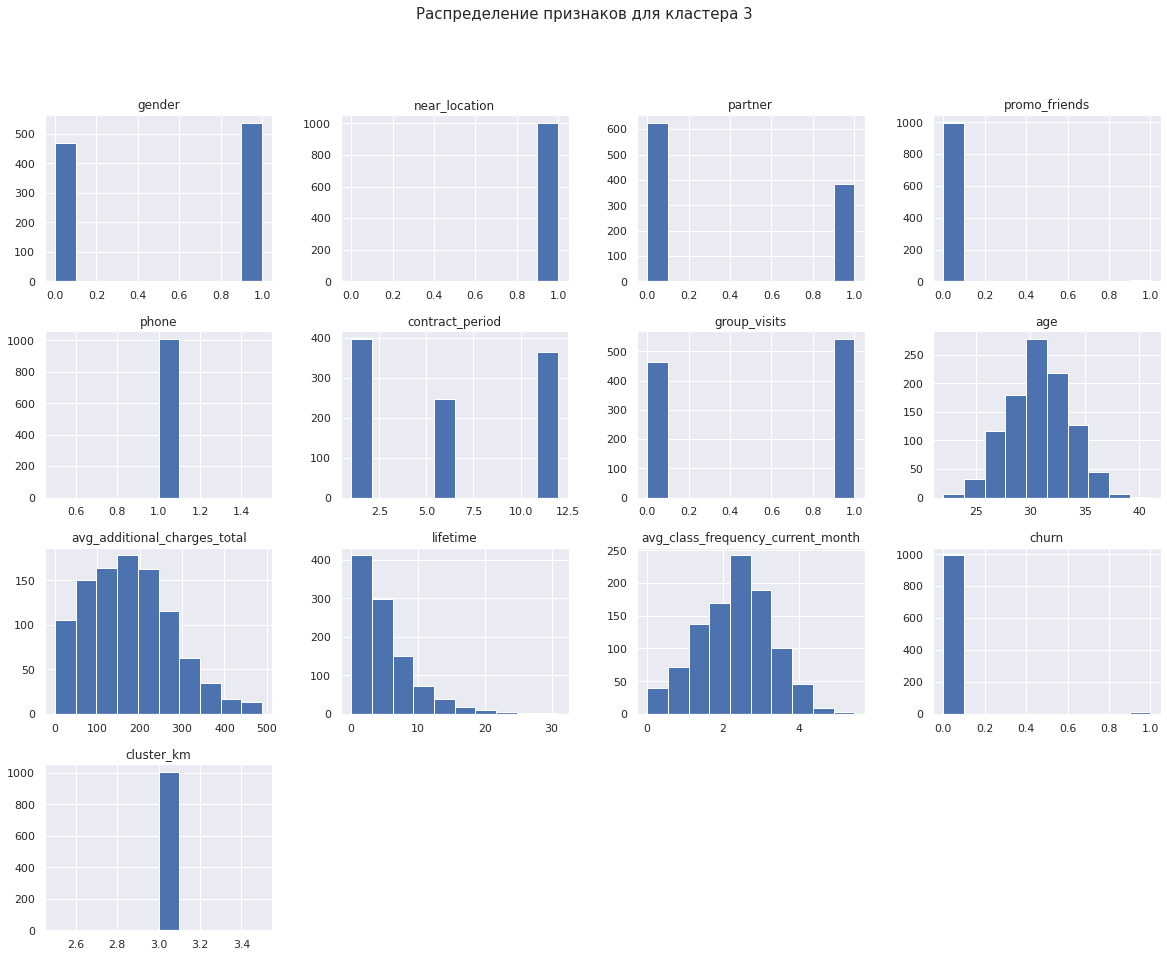

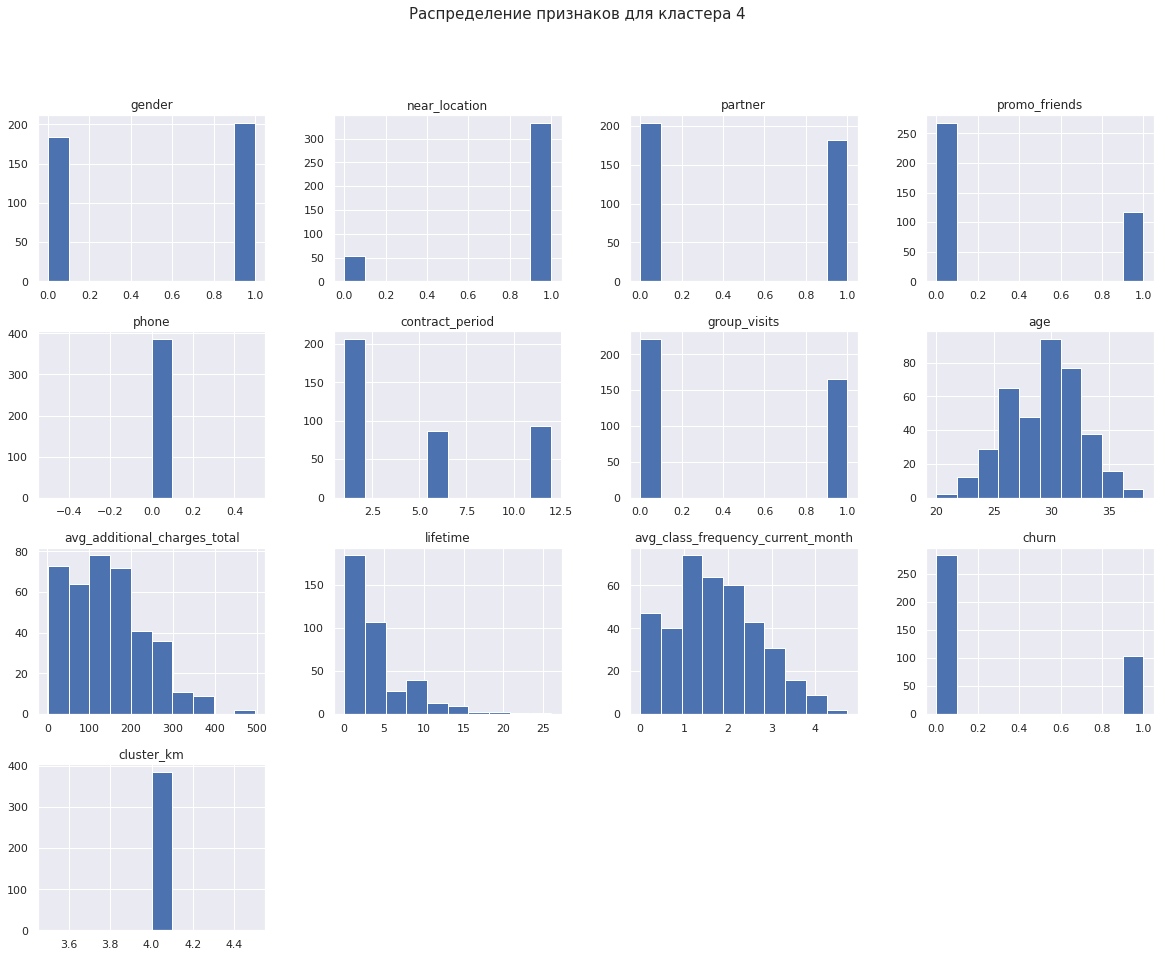

In [29]:
for value in [0, 1, 2, 3, 4]:
    gym_churn[gym_churn['cluster_km']==value].hist(figsize=(20,15))
    plt.suptitle('Распределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

- Методом groupby() посчитаем долю оттока для каждого полученного кластера. 

In [30]:
(gym_churn
     .groupby('cluster_km')['churn']
     .mean()
     .reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True))

,cluster_km,churn
0,2,0.56
1,1,0.40
2,4,0.27
3,0,0.12
4,3,0.01


Сильнее всего склонны к оттоку кластеры 2 и 1, кластеры 4 и 0 более надёжны.  
Самыми преданными являются клиенты кластера номер 3. 

**Вывод по разделу:**

Более лояльными являются клиенты ближе к 30 годам, уже успевшие познакомиться со спектром услуг фитнес-центра. Чаще всего это сотрудники компании-партнёра и участники акции «приведи друга». Эти люди живут или работают поблизости, они занимаются в группах, покупают абонементы на более длительный срок. 

Немаловажным фактором является связь с клиентом, мы получили более 25% оттока в 4 кластере, где никто не указал контактный телефон. Также в зону риска попадают молодые одинокие новички, вероятно среди пользователей фитнес-центра образовалось некое сообщество, в которое непросто влиться. Возможно заказчику следует сделать упор на активное сопровождение клиентов в первые месяц 1-2 месяца, особенно для тех, кто пришел сам (не от компании-партнера и не по акции).

## Выводы и рекомендации

Резюмируя, можно выделить определенные группы клиентов: 

- не проживают / работают рядом с фитнес центром (более склонны к оттоку)
- не являются сотрудниками компании-партнера (более склонны к оттоку)
- возрастная группа 25-27 лет (более склонны к оттоку)
- новые клиенты в пределах 1-2 месяцев (более склонны к оттоку)

В ходе исследования удалось выявить определенные точки роста, проанализировав их можно предложить следующие рекомендации по дальнейшей работе: 

1. Оптимизация сопровождения новых клиентов: тщательный мониторинг их посещений, подробные экскурсии по фитнес-ценру, полное 
   информационное сопровождение по спектру услуг, предоставление бесплатных (или с хорошей скидкой) индивидуальных занятий с 
   тренером, создание приятной атмосферы.
   
   
2. Изменение ценовой политики, возможно увеличение цены на абонементы сроком на 1 месяц.
   Однако второй пункт не отменяет первый, если атмосфера останется недружелюбной клиент все равно уйдет в отток.
   
   
3. Мероприятия по повышению вовлеченности новых клиентов в групповые занятия. Возможно внедрение бонусов для постоянных
   клиентов ставших наставниками для новичков.  
   

4. Внедрение дополнительных бонусных программ на дополнительные услуги фитнес-центра для владельцев длительных абонементов (6 и    12 месяцев).


5. Еженедельный мониторинг посещений всех клиентов, ненавязчивые информационные звонки/рассылки (мероприятия по предотвращению 
   оттока). Можно информировать о наличии новых групп, тренеров, спортивных программ или напоминать о дополнительных услугах, как о возможности отдыха. 
   
   
6. Также стоит рассмотреть предоставление возможности «заморозить» абонемента на месяц (который, к примеру, можно разбить). 